In [1]:
import csv
import random
import math
import operator
import cv2
import matplotlib.pyplot as plt
import knn_classifier
import numpy as np

In [13]:
def rgb2hsv(r, g, b):
    # from RGB to HSV color space
    # R, G, B values are [0, 255]. H value is [0, 360]. S, V values are [0, 1]

    r = r / 255.0
    g = g / 255.0
    b = b / 255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = df/mx
    v = mx
    return h, s, v

def detectShape(path):
    # for detecting the contour of the pill and its length, and the pill's predicted color

    img= cv2.imread(path,1)
    imgheight= img.shape[0]
    imgwidth = img.shape[1]
    img = cv2.resize(img, (int(imgwidth * (480 / imgheight)), 480))
    img = cv2.GaussianBlur(img, (3,3), 0) # Gaussian blurring to remove noise in the image 
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # img = cv2.filter2D(img, -1, kernel)

    drugShape = 'UNDEFINED' # initializing the drug shape
    edges = cv2.Canny(img,100,200) # detecting the edges to identify the pill
    contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # finding the contours in the image

    areas = np.array([cv2.contourArea(c) for c in contours]) # array of the areas of all contours
    contours = np.array(contours) # array of all contours in the image 
    arr1inds = areas.argsort() # sorting contours
    contours = contours[arr1inds[::-1]] # descendingly, as the pill will be tha largest contour

    approx = cv2.approxPolyDP(contours[0], 0.01*cv2.arcLength(contours[0],True), True)	
    x,y,w,h = cv2.boundingRect(contours[0]) # offsets - with this you get 'mask'

    cv2.drawContours(img, [contours[0]], 0,(255,0,0), 2)

    # to get the average of the colors inside the largest contour "inside the pill"
    newIM = img[y:y+h,x:x+w]
    yn = newIM.shape[0]
    xn = newIM.shape[1]

    y=y + int(yn * 20/100)
    h=h - int(yn * 40/100)
    x=x + int(xn * 20/100) 
    w=w - int(xn * 30/100)

    newImage = img[y:y+h,x:x+w] # inside the contour
    colors = np.array(cv2.mean(newImage)).astype(np.uint8) # average of the colors inside newImage
    prediction = 'n.a.'

    # increase saturation before white detection for light colors elimination
    hsvImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2HSV)
    hsvImage[:,:,1]=hsvImage[:,:,1] * 2.5 # increasing the saturation of the color
    backImage = cv2.cvtColor(hsvImage, cv2.COLOR_HSV2BGR)

    # using BGR
    backColors = np.array(cv2.mean(backImage)).astype(np.uint8) # average of colors after increasing the saturation
    # the prediction of the color classifier RGB
    prediction = knn_classifier.main('training.data', np.array([backColors[2], backColors[1], backColors[0]]))
    if prediction =='white': # for white only not the light colors
        #RED GREEN BLUE
        if backColors[2] >= 180 and backColors[1] >= 150 and backColors[0] <= 90 : # it will not be white using trial and error
            prediction = 'other'	
        else:
            backColors = np.array(cv2.mean(newImage)).astype(np.uint8) # average of colors after increasing the saturation
            # the prediction of the color classifier RGB
            prediction = knn_classifier.main('training.data', np.array([backColors[2], backColors[1], backColors[0]]))
            
            if backColors[2] >= 180 and backColors[1] >= 150 and backColors[0] <= 90 : # it will not be white using trial and error
                prediction = 'other'

    if prediction == 'other':
        # using HSV
        colors = rgb2hsv(colors[2], colors[1], colors[0])
        # the prediction of the color classifier HSV
        prediction = knn_classifier.main('newData.data', np.array([colors[0], colors[1], colors[2]]))
    return len(approx), prediction, contours[0]

def detectDrug(path):
    # for detecting pill's shape and color

    lenn, color, contour = detectShape(path)
    # "lenn" to detect the shape whether it is ellipse, hexagon, pentagon, square, rectangle or circle according to the length of the contour
#     print(lenn,color)
    drugShape= 'UNDEFINED' # initialization
    drugName= 'UNDEFINED'
    # print(lenn)

    # using trial and error
    if 5 < lenn < 12:
        drugShape = 'Ellipse'
    elif lenn == 6:
        drugShape = 'Hexagon'
    elif lenn == 5:
        drugShape = 'Pentagon'
    elif lenn == 4:
        x,y,w,h = cv2.boundingRect(contour)
        ar = w / float(h)
        drugShape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
    elif lenn >= 12:
        drugShape = 'Circle'

    return drugShape, color

def getName(path):
    # to get the name of the pill using its shape and color

    Name = 'UNDEFINED'
    dictt = {} # dictionary of (shape, color) key 
    #Milga
    dictt[("Circle", "red")] = "Milga"
    #Panadol
    dictt[("Ellipse", "white")] = "Panadol"
    #Brufen
    dictt[("Circle", "pink")] = "Brufen"
    #Ketofan
    dictt[("Ellipse", "yellow")] = "Ketofan"
    #Paracetamol
    dictt[("Circle", "white")] = "Paracetamol"
    #Comtrex
    dictt[("Ellipse", "red")] = "Comtrex"
    #Alphintern
    dictt[("Circle", "blue")] = "Alphintern"
    #Cataflam
    dictt[("Circle", "orange")] = "Cataflam"

    drugShape, color = detectDrug(path)
    Name = dictt[(drugShape, color)]
    return Name


try:
    print('Expected: ', 'test','Result: ',getName('download.png'))
except:
    pass
#testing
# print('Expected: ', 'Milga','Result: ',getName('images/milga2.jpg'))
# print('Expected: ', 'Milga','Result: ',getName('images/milga3.jpg'))

13 blue
('Circle', 'blue')


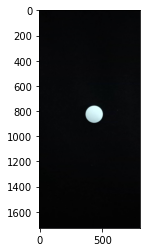

In [3]:
path = "images/alpha1.jpg"
print(detectDrug(path))
img = plt.imread(path)
plt.imshow(img)
plt.show()

('Ellipse', 'white')


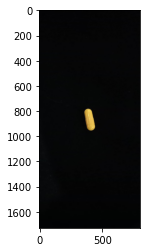

In [17]:
path = "images/kito2.jpg"
print(detectDrug(path))
img = plt.imread(path)
plt.imshow(img)
plt.show()

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
getName(path)

'Panadol'

In [14]:
n = getName(path)

In [15]:
n

'Panadol'

In [19]:
a,b =detectDrug(path)

In [20]:
a

'Ellipse'